In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = 'cerberus_annot.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']

In [3]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [4]:
df = pd.DataFrame()
df['gid'] = []
df['source'] = []
df['sector'] = []
for source in ['obs_major', 'obs_det']:
    temp = ca.triplets.loc[ca.triplets.source == source]
    temp = assign_gisx_sector(temp)
    temp = temp[['gid', 'source', 'sector']]
    df = df.merge(temp, how='outer', on='gid', suffixes=('', '_{}'.format(source)))

df.drop(['source', 'sector'], axis=1, inplace=True)

In [5]:
# temp fix until I make sure I'm only considering isoforms >= 1 tpm in major set
df = df.loc[~df.source_obs_det.isnull()]

In [6]:
df.loc[df.source_obs_det.isnull()]

,gid,source_obs_major,sector_obs_major,source_obs_det,sector_obs_det


In [7]:
# check to see where nan source_obs_dets are coming from
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df,
#                how='iso',
#                min_tpm=0)
# df.reset_index(inplace=True)
# beep = df.loc[df.annot_transcript_id.str.contains('ENSG00000285978')].set_index('annot_transcript_id').transpose()
# beep.loc[beep['ENSG00000285978[1,1,1]']>0]

In [8]:
df.drop(['source_obs_major', 'source_obs_det'], axis=1, inplace=True)
df = df.groupby(['sector_obs_major', 'sector_obs_det']).count().reset_index()

In [9]:
df.head()

,sector_obs_major,sector_obs_det,gid
0,mixed,mixed,7754
1,mixed,splicing,268
2,mixed,tes,649
3,mixed,tss,305
4,simple,mixed,274


In [10]:
df.head()

,sector_obs_major,sector_obs_det,gid
0,mixed,mixed,7754
1,mixed,splicing,268
2,mixed,tes,649
3,mixed,tss,305
4,simple,mixed,274


In [11]:
# #Sort by Source and then Destination
# df['source'] = pd.Categorical(df['source'], ['Formal','Informal', 'Unemployed', 'Inactive'])
# df['destination'] = pd.Categorical(df['destination'], ['Formal','Informal', 'Unemployed', 'Inactive'])
# df.sort_values(['source', 'destination'], inplace = True)
# df.reset_index(drop=True)

{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


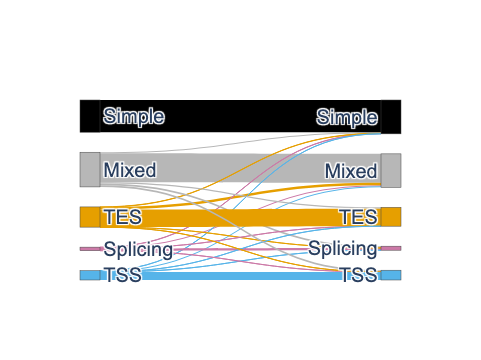

In [21]:
ofile = 'figures/obs_det_obs_major_sankey.pdf'
fig = plot_sankey(df,
                  source='sector_obs_det',
                  sink='sector_obs_major',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)

In [18]:
total_det = df[['sector_obs_det', 'gid']].groupby('sector_obs_det').sum().reset_index()
total_det.rename({'gid': 'total'}, axis=1, inplace=True)
total_det.head()

,sector_obs_det,total
0,mixed,9288
1,simple,8633
2,splicing,946
3,tes,5417
4,tss,2497


In [19]:
df[['sector_obs_major', 'gid']].groupby('sector_obs_major').sum().reset_index()


,sector_obs_major,gid
0,mixed,8976
1,simple,9066
2,splicing,1076
3,tes,5042
4,tss,2621


In [15]:
df = df.merge(total_det, how='left', on='sector_obs_det')

In [16]:
df['perc'] = (df['gid']/df['total'])*100

In [17]:
df.loc[df.sector_obs_major==df.sector_obs_det]

,sector_obs_major,sector_obs_det,gid,source,sink,total,perc
0,mixed,mixed,7754,1,6,9288,83.484065
5,simple,simple,8633,0,5,8633,100.000000
10,splicing,splicing,599,3,8,946,63.319239
15,tes,tes,4669,2,7,5417,86.191619
20,tss,tss,2146,4,9,2497,85.943132


{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


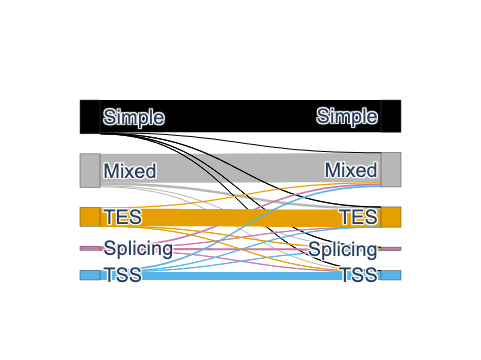

In [20]:
# what about the other way around?

ofile = 'figures/obs_major_obs_det_sankey.pdf'
fig = plot_sankey(df,
                  source='sector_obs_major',
                  sink='sector_obs_det',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)